# Presidential Election 2020

In [3]:
#Install the required libraries
!pip install langdetect
!pip install transformers huggingface_hub
!pip install transformers[sentencepiece]
!pip install tmtoolkit

#Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import re
from IPython.display import display
import datetime as dt
from itertools import product

#Libraries for NLP
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji
from nltk.stem import WordNetLemmatizer

#Libraries for textblob
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

#imports for TweetNLP
import torch
import sentencepiece
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import pipeline
from huggingface_hub import notebook_login
from scipy.special import softmax

#imports from pysentimiento

#imports for topic modelling
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim



c:\Users\danie\Coding\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

### Load data

In [99]:
#Get the data out
def load_data(path):
    data = pd.read_csv(path, header = 0, lineterminator='\n')
    return data

In [100]:
#load trump and biden data
trump_path = 'data/hashtag_donaldtrump.csv'
trump_data = load_data(trump_path)

biden_path ='data/hashtag_joebiden.csv'
biden_data = load_data(biden_path)

In [101]:
#Inspect trump dataset
trump_data.info()
trump_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            970919 non-null  object 
 1   tweet_id              970919 non-null  float64
 2   tweet                 970919 non-null  object 
 3   likes                 970919 non-null  float64
 4   retweet_count         970919 non-null  float64
 5   source                970043 non-null  object 
 6   user_id               970919 non-null  float64
 7   user_name             970897 non-null  object 
 8   user_screen_name      970919 non-null  object 
 9   user_description      869651 non-null  object 
 10  user_join_date        970919 non-null  object 
 11  user_followers_count  970919 non-null  float64
 12  user_location         675957 non-null  object 
 13  lat                   445719 non-null  float64
 14  long                  445719 non-null  float64
 15  

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he is VERY busy. Tremendously busy.,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we be worried?",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,covering Capitol Hill &DC politics in Arabic for 15+yrs. Mom of identical twins. Beach, chocolate & gym lover.",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [102]:
biden_data.info()
biden_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            776886 non-null  object 
 1   tweet_id              776886 non-null  float64
 2   tweet                 776886 non-null  object 
 3   likes                 776886 non-null  float64
 4   retweet_count         776886 non-null  float64
 5   source                776173 non-null  object 
 6   user_id               776886 non-null  float64
 7   user_name             776861 non-null  object 
 8   user_screen_name      776886 non-null  object 
 9   user_description      694877 non-null  object 
 10  user_join_date        776886 non-null  object 
 11  user_followers_count  776886 non-null  float64
 12  user_location         543092 non-null  object 
 13  lat                   355293 non-null  float64
 14  long                  355293 non-null  float64
 15  

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #BidenEmail #Corruption https://t.co/C6clrtshQl,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,"A Silicon Valley #independent #News #Media #Startup\n *If you have any tips you'd like us to cover, please DM or tag us*",...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


### Add column for candidate name

In [103]:
#Function to add candidate name to the tweets
def candidate_name(data,name:str):
    assert isinstance(name, str), 'Strings only!'
    
    #Drop the column if it exist
    if 'candidate_name' in data.columns:
        data.drop('candidate_name', axis=1, inplace=True)

    data['candidate_name'] = name
    return data

In [104]:
#label all the trump tweets as trump and all biden tweets as biden
trump_name = candidate_name(trump_data,'trump')
biden_name = candidate_name(biden_data,'biden')

In [105]:
#Check that the new columnn is there
trump_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970919 entries, 0 to 970918
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            970919 non-null  object 
 1   tweet_id              970919 non-null  float64
 2   tweet                 970919 non-null  object 
 3   likes                 970919 non-null  float64
 4   retweet_count         970919 non-null  float64
 5   source                970043 non-null  object 
 6   user_id               970919 non-null  float64
 7   user_name             970897 non-null  object 
 8   user_screen_name      970919 non-null  object 
 9   user_description      869651 non-null  object 
 10  user_join_date        970919 non-null  object 
 11  user_followers_count  970919 non-null  float64
 12  user_location         675957 non-null  object 
 13  lat                   445719 non-null  float64
 14  long                  445719 non-null  float64
 15  

In [59]:
#Check that the new column is there
biden_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            776886 non-null  object 
 1   tweet_id              776886 non-null  float64
 2   tweet                 776886 non-null  object 
 3   likes                 776886 non-null  float64
 4   retweet_count         776886 non-null  float64
 5   source                776173 non-null  object 
 6   user_id               776886 non-null  float64
 7   user_name             776861 non-null  object 
 8   user_screen_name      776886 non-null  object 
 9   user_description      694877 non-null  object 
 10  user_join_date        776886 non-null  object 
 11  user_followers_count  776886 non-null  float64
 12  user_location         543092 non-null  object 
 13  lat                   355293 non-null  float64
 14  long                  355293 non-null  float64
 15  

### Merge the 2 dataframes together

In [106]:
#Function to merge 2 dataframes together
def merge_df(data1, data2):
    #Check to make sure that both dataframe have the same headers
    assert list(data1.columns) == list(data2.columns), "The dataframes do not have the same column headers."
    combine_data = pd.concat([data1,data2], ignore_index = True)
    return combine_data

In [107]:
#merge the 2 datassets together
combine_data = merge_df(trump_name, biden_name)
#Check that the number of data is correct
combine_data.count() #Should have about 1.7million (776886+970919)

created_at              1747805
tweet_id                1747805
tweet                   1747805
likes                   1747805
retweet_count           1747805
source                  1746216
user_id                 1747805
user_name               1747758
user_screen_name        1747805
user_description        1564528
user_join_date          1747805
user_followers_count    1747805
user_location           1219049
lat                      801012
long                     801012
city                     414059
country                  796527
continent                796562
state                    580815
state_code               545034
collected_at            1747805
candidate_name          1747805
dtype: int64

### Drop duplicates 

In [108]:
# Check for duplicate rows in the entire DataFrame
duplicates = combine_data['tweet'].duplicated()
print(f"The number of duplicates: {duplicates.sum()}")

The number of duplicates: 240600


In [109]:
# Drop duplicates based on 'tweet' - keep biden tweet so that it is more equal
combine_data = combine_data.drop_duplicates(subset=['tweet'], keep ='last')

In [111]:
# Count the number of tweets for each candidate
tweet_counts = combine_data['candidate_name'].value_counts()

# Display the result
print(tweet_counts)

candidate_name
biden    768387
trump    738818
Name: count, dtype: int64


### Filter US tweets and have state

In [112]:
#check the distinct names of the country. Only pick those countries with data filled
sorted([country for country in combine_data['country'].unique() if isinstance(country, str)])

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'British Virgin Islands',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Congo-Brazzaville',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Falkland Islands',
 'Faroe Islands',
 'Federated States of Micronesia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti'

In [113]:
def filter_country(data, country:list):
    #Assert that the country is a list of strings
    assert isinstance(country, list) and all(isinstance(c, str) for c in country), "Provide a list of strings as the country filter."
    #Filter out all the US country with state
    data = data[data['country'].isin(country) & data['state'].notna()]

    return data

In [114]:
# US country has 2 names: 'United States','United States of America',
country = ['United States','United States of America']
us_tweets = filter_country(combine_data, country)

In [115]:
#Check how many tweets are left
us_tweets.count()

created_at              297506
tweet_id                297506
tweet                   297506
likes                   297506
retweet_count           297506
source                  297490
user_id                 297506
user_name               297505
user_screen_name        297506
user_description        280414
user_join_date          297506
user_followers_count    297506
user_location           297506
lat                     297506
long                    297506
city                    170305
country                 297506
continent               297506
state                   297506
state_code              297506
collected_at            297506
candidate_name          297506
dtype: int64

In [116]:
#Check if all the state are actually US states
Counter(sorted(us_tweets['state']))
#Realise that there are some US territories, such as Guam, Northern marinana Island, Perto Rico

Counter({'California': 51202,
         'New York': 38480,
         'Texas': 27454,
         'Florida': 26521,
         'District of Columbia': 14352,
         'Pennsylvania': 11221,
         'Illinois': 11061,
         'New Jersey': 8241,
         'Massachusetts': 7767,
         'Ohio': 7665,
         'North Carolina': 5716,
         'Arizona': 5634,
         'Michigan': 5558,
         'Colorado': 5462,
         'Georgia': 5316,
         'Oregon': 4933,
         'Washington': 4445,
         'Virginia': 4276,
         'Nevada': 4097,
         'Tennessee': 3908,
         'Maryland': 3852,
         'Missouri': 3697,
         'Minnesota': 3155,
         'Wisconsin': 2877,
         'Indiana': 2658,
         'Kentucky': 2398,
         'South Carolina': 2025,
         'Louisiana': 1935,
         'Connecticut': 1817,
         'Kansas': 1644,
         'Alabama': 1542,
         'Utah': 1478,
         'Oklahoma': 1460,
         'Iowa': 1320,
         'Hawaii': 1249,
         'Vermont': 1075,
    

In [117]:
#Added in District of Columbia
state_names=["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming", "District of Columbia"]
len(state_names)

51

In [118]:
def filter_state(data, state:list):
    #Assert that the country is a list of strings
    assert isinstance(state, list) and all(isinstance(c, str) for c in state), "Provide a list of strings as the state filter."
    #Filter out all 51 states
    data = data[data['state'].isin(state_names)]

    return data

In [119]:
us_state = filter_state(us_tweets,state_names)

In [120]:
us_state.info()
#Check if correct = 297506 - 9 (guam) -1 (Northern M. island) - 996 (Perto Rico)

<class 'pandas.core.frame.DataFrame'>
Index: 296599 entries, 2 to 1747791
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            296599 non-null  object 
 1   tweet_id              296599 non-null  float64
 2   tweet                 296599 non-null  object 
 3   likes                 296599 non-null  float64
 4   retweet_count         296599 non-null  float64
 5   source                296583 non-null  object 
 6   user_id               296599 non-null  float64
 7   user_name             296598 non-null  object 
 8   user_screen_name      296599 non-null  object 
 9   user_description      279521 non-null  object 
 10  user_join_date        296599 non-null  object 
 11  user_followers_count  296599 non-null  float64
 12  user_location         296599 non-null  object 
 13  lat                   296599 non-null  float64
 14  long                  296599 non-null  float64
 15  city

### Tweet Cleaning and Language filtering

In [121]:
def check_language_test(tweet, language='en'):
    try:
        detected_language = detect(tweet)
        if detected_language == language:  # Check if the tweet is in the specified language
            return None
        
        elif detected_language != language:
            return detected_language
        
    except LangDetectException:
        return 'unknown'

In [122]:
def non_english_test(data, col_name = 'tweet', num_tweets=1000, seed_value =0, language = 'en'):
    DetectorFactory.seed = seed_value

    # Start timing
    start_time = time.time()

    # List to store non-English tweets and their languages
    non_english_tweets = []

    # Loop through the first 1000 tweets and check their language
    for index, text in data[col_name].iloc[:num_tweets].items():
        detected_lang = check_language_test(text, language)
        if detected_lang:  # If the tweet is non-English
            non_english_tweets.append((text, detected_lang))

    # Stop timing
    stop_time = time.time()

    time_taken = stop_time - start_time

    return non_english_tweets, time_taken

In [123]:
# Assuming 'us_state' is your DataFrame with a 'tweet' column
non_english_tweets, time_taken = non_english_test(us_state, col_name='tweet', language = 'en')

# Output the results
print(f"Number of non-English tweets: {len(non_english_tweets)}")
for tweet, lang in non_english_tweets:
    print(f"Tweet: {tweet} | Detected Language: {lang}")
print(f"Time taken: {time_taken:.2f} seconds")

Number of non-English tweets: 58
Tweet: @JoeBiden #donaldtrump 4 more years! | Detected Language: da
Tweet: @JoeBiden #BidenHarris2020 #DonaldTrump #HunterBiden https://t.co/tBDFpoEdzX | Detected Language: nl
Tweet: #MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trump #TrumpKillsUs #TrumpIsNotWell #VetsAgainstTrump #Veteran #VeteransForTrump #LindseyMustGo #LadyG #MoscowMitch #MoscowMitchTraitor #MitchMcConnell #LindseyGraham https://t.co/hdF2EXdb8P | Detected Language: de
Tweet: #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #Trump OUT! #TrumpVirus | Detected Language: nl
Tweet: #MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trump #TrumpKillsUs #TrumpIsNotWell #VetsAgainstTrump #Veteran #VeteransForTrump #Veteran #LindseyMustGo #MoscowMitch #MoscowMitchTraitor #MitchMcConnell #LindseyGraham https://t.co/IqBi7HariM | Detected Language: de
Tweet: L'aveva detto #Tr

The langdetect is unable to detect accurately when the tweet is too short, or contains mostly hashtags and link. Maybe lets try cleaning it first before we try to let it detect the language

In [124]:
#Remove all emoji
def replace_emoji(tweet):
    #Convert emoji to text
    return emoji.demojize(tweet, delimiters=(" ", " "))

In [125]:
#Remove all the links
def tweet_normalize(tweet):
    # Replace user mentions with @USER
    tweet = re.sub(r'@\w+', '@user', tweet)

    #Remove all the urls - do not think they are impt
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

    #Use strip to remove leading and trailing whitespace
    tweet = tweet.strip()

    # Replace newlines (\n or \r) with a space
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet

In [126]:
def preprocess_tweet(tweet):
    tweet = replace_emoji(tweet)
    tweet = tweet_normalize(tweet)
    return tweet

In [127]:
# Check if 'clean_tweet' column exists and remove it if it does
if 'clean_tweet' in us_state.columns:
    us_state.drop('clean_tweet', axis=1, inplace=True)

#Clean out the url and put into a new column called clean_tweet - can avoid warning also
us_state = us_state.assign(clean_tweet=us_state['tweet'].apply(preprocess_tweet))

In [128]:
#Check that the clean tweet column is out
us_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296599 entries, 2 to 1747791
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            296599 non-null  object 
 1   tweet_id              296599 non-null  float64
 2   tweet                 296599 non-null  object 
 3   likes                 296599 non-null  float64
 4   retweet_count         296599 non-null  float64
 5   source                296583 non-null  object 
 6   user_id               296599 non-null  float64
 7   user_name             296598 non-null  object 
 8   user_screen_name      296599 non-null  object 
 9   user_description      279521 non-null  object 
 10  user_join_date        296599 non-null  object 
 11  user_followers_count  296599 non-null  float64
 12  user_location         296599 non-null  object 
 13  lat                   296599 non-null  float64
 14  long                  296599 non-null  float64
 15  city

BERTweet model are trained to read emoji and hashtags. There is no need to remove all these. 

In [129]:
# Test it with the clean_tweet and see if there is a difference
non_english_tweets_cleaned, time_taken = non_english_test(us_state, col_name='clean_tweet')

# Output the results
print(f"Number of non-English tweets: {len(non_english_tweets_cleaned)}")
for tweet, lang in non_english_tweets_cleaned:
    print(f"Tweet: {tweet} | Detected Language: {lang}")
print(f"Time taken: {time_taken:.2f} seconds")

Number of non-English tweets: 46
Tweet: @user #BidenHarris2020 #DonaldTrump #HunterBiden | Detected Language: de
Tweet: #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #BidenHarris #Trump OUT! #TrumpVirus | Detected Language: nl
Tweet: #MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trump #TrumpKillsUs #TrumpIsNotWell #VetsAgainstTrump #Veteran #VeteransForTrump #Veteran #LindseyMustGo #MoscowMitch #MoscowMitchTraitor #MitchMcConnell #LindseyGraham | Detected Language: de
Tweet: L'aveva detto #Trump che la campagna elettorale cominciava il 15 Ottobre! @user @user | Detected Language: it
Tweet: Original content #IceCube #trump | Detected Language: ro
Tweet: #DonaldTrump | Detected Language: ro
Tweet: #MAGA #Trump #MAGA2020 #Trump2020 #GOP middle_finger middle_finger middle_finger | Detected Language: da
Tweet: #Trump rechazó apoyo de talibanes a su campaña de reelección. | 

Improvement in the number of tweets being viewed as non_english. Improve from 5.8%--> 4.6%
Still unable to accurate identify the language of the tweets when it is all hashtags. 

In [130]:
def compare_cleaned_vs_uncleaned(df, clean_col='clean_tweet', unclean_col='tweet', col_num = 1000, seed_value =0):
    DetectorFactory.seed = seed_value
    # Create lists to store the differences
    differences = []

    # Iterate through each row in the DataFrame
    for index, row in df.head(col_num).iterrows():
        clean_tweet = row[clean_col]
        unclean_tweet = row[unclean_col]
        
        try:
            # Detect languages directly
            clean_lang = detect(clean_tweet)
            unclean_lang = detect(unclean_tweet)
            
        except LangDetectException:
            # Handle the case where language detection fails for either tweet
            clean_lang = 'unknown'
            unclean_lang = 'unknown'
        
        # If the detected languages differ, store the tweet and language info
        if clean_lang =='en' and unclean_lang != 'en':
            differences.append({
                'index': index,
                'clean_tweet': clean_tweet,
                'unclean_tweet': unclean_tweet,
                'clean_lang': clean_lang,
                'unclean_lang': unclean_lang
            })
    return differences

In [131]:
differences = compare_cleaned_vs_uncleaned(us_state)
# Output the results
print(f"Number of tweets with differing language detection: {len(differences)}")
display(pd.DataFrame(differences))

Number of tweets with differing language detection: 13


,index,clean_tweet,unclean_tweet,clean_lang,unclean_lang
0,75,@user #donaldtrump 4 more years!,@JoeBiden #donaldtrump 4 more years!,en,da
1,137,#MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trump #TrumpKillsUs #TrumpIsNotWell #VetsAgainstTrump #Veteran #VeteransForTrump #LindseyMustGo #LadyG #MoscowMitch #MoscowMitchTraitor #MitchMcConnell #LindseyGraham,#MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trump #TrumpKillsUs #TrumpIsNotWell #VetsAgainstTrump #Veteran #VeteransForTrump #LindseyMustGo #LadyG #MoscowMitch #MoscowMitchTraitor #MitchMcConnell #LindseyGraham https://t.co/hdF2EXdb8P,en,de
2,288,prohibited #TRUMP prohibited,🚫#TRUMP 🚫,en,vi
3,376,@user ✓ United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States Trump United_States #Trump2020Landslide United_States #Trump2020 United_States #Trump United_States,@JoeBiden ✓🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸Trump 🇺🇸#Trump2020Landslide🇺🇸 #Trump2020 🇺🇸#Trump🇺🇸,en,id
4,1014,backhand_index_pointing_down #Trump,👇 #Trump https://t.co/2Gqz6WJjsz,en,vi
5,1144,@user Wohoooooo #TRUMP MAGA!!!!!,@GeorgeTakei Wohoooooo #TRUMP MAGA!!!!!,en,af
6,1176,@user Nope thumbs_down_medium-light_skin_tone just #tRump,@Omega_Manx Nope 👎🏼 just #tRump,en,et
7,1598,"Days 10, 11, 12 double_exclamation_mark MAKE SURE YOU VOTE double_exclamation_mark #inktober #ink #inktober2020 #inking #sketch #sketchbook #sketching #drawing #drawing #sppoky #blackandwhite #day10 #day11 #day12 #hope #disgusting #slippery #trump","Days 10, 11, 12 \n‼️MAKE SURE YOU VOTE‼️\n\n#inktober #ink #inktober2020 #inking #sketch #sketchbook #sketching #drawing #drawing #sppoky #blackandwhite #day10 #day11 #day12 #hope #disgusting #slippery #trump https://t.co/kWpjdYto3f",en,af
8,1936,"Vote #RED, vote #INPERSON, vote #Trump! @user peach United_States","Vote #RED, vote #INPERSON, vote #Trump! @realDonaldTrump 🍑 🇺🇸 https://t.co/h4eMewSHvB",en,ro
9,1939,@user @user #Trump for Resident (Prison) 2021,@real_defender @realDonaldTrump #Trump for Resident (Prison) 2021,en,da


In [132]:
#Function to return all the english tweets if it is true
def detect_english_tweets(text):
    try:
        lang = detect(text)
        # Return True if the language is English
        return lang == 'en'
    except LangDetectException:
        # If language detection fails, return False
        return False

In [133]:
english_tweets = us_state[us_state['clean_tweet'].apply(detect_english_tweets)]
#Ran for 15 mins

In [142]:
#Check how many english tweets are there
english_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265350 entries, 2 to 1747791
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   created_at            265350 non-null  datetime64[ns]
 1   tweet_id              265350 non-null  float64       
 2   tweet                 265350 non-null  object        
 3   likes                 265350 non-null  float64       
 4   retweet_count         265350 non-null  float64       
 5   source                265334 non-null  object        
 6   user_id               265350 non-null  float64       
 7   user_name             265349 non-null  object        
 8   user_screen_name      265350 non-null  object        
 9   user_description      250571 non-null  object        
 10  user_join_date        265350 non-null  object        
 11  user_followers_count  265350 non-null  float64       
 12  user_location         265350 non-null  object        
 13  lat

The number of tweets lost = (296599-265350)/296599 *100%  = 10.5% loss

### Tokenizing + hashtags for word cloud/topic modeling

In [135]:
#download if don't have
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [136]:
#Get all the important words for wordcloud
def remove_stopwords(tweet):
    #Change all the tweets to lowercase
    tweet = tweet.lower()

    #Tokenize the tweets using tweet tokenizer
    tokenizer = TweetTokenizer()
    tokenized = tokenizer.tokenize(tweet)

    #Get all the stopwords
    stop_words = set(stopwords.words('english'))

    #Initialize the wordNet lemmatizer
    lemmatizer = WordNetLemmatizer()

    #Remove all the stopwords
    tokenized = [lemmatizer.lemmatize(token) #lemmatize the token 
                 for token in tokenized 
                 if (token.isalpha() or token.startswith('#')) #keep words and hashtags
                 and len(token) > 3 #Keep tokens that are 3 characters or longer
                 and token not in stop_words #Exclude stopwords
                 and not token.startswith('@') #Remove all the @user
    ]

    return tokenized

In [137]:
#Remove the column if the column exist. This is to prevent duplicate
if 'no_stopwords' in english_tweets.columns:
    english_tweets.drop('no_stopwords', axis=1)

#Put the words into column no_stopwords
english_tweets = english_tweets.assign(no_stopwords=english_tweets['clean_tweet'].apply(remove_stopwords))

In [138]:
#Check that the column is there
english_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265350 entries, 2 to 1747791
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            265350 non-null  object 
 1   tweet_id              265350 non-null  float64
 2   tweet                 265350 non-null  object 
 3   likes                 265350 non-null  float64
 4   retweet_count         265350 non-null  float64
 5   source                265334 non-null  object 
 6   user_id               265350 non-null  float64
 7   user_name             265349 non-null  object 
 8   user_screen_name      265350 non-null  object 
 9   user_description      250571 non-null  object 
 10  user_join_date        265350 non-null  object 
 11  user_followers_count  265350 non-null  float64
 12  user_location         265350 non-null  object 
 13  lat                   265350 non-null  float64
 14  long                  265350 non-null  float64
 15  city

In [139]:
# Adjust pandas settings to display full text in columns without truncation
pd.set_option('display.max_colwidth', None)

#View how the first 20 original text, clean text and stopwords look like
display(english_tweets[['tweet', 'clean_tweet', 'no_stopwords']].head(10))


,tweet,clean_tweet,no_stopwords
2,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?","#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million. Um. What?","[#trump, student, used, hear, year, year, heard, china, know, many, asked, many, said, know, million, like, million]"
4,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,You get a tie! And you get a tie! #Trump ‘s rally #Iowa,"[#trump, rally, #iowa]"
5,@CLady62 Her 15 minutes were over long time ago. Omarosa never represented the black community! #TheReidOut \n\nShe cried to #Trump begging for a job!,@user Her 15 minutes were over long time ago. Omarosa never represented the black community! #TheReidOut She cried to #Trump begging for a job!,"[minute, long, time, omarosa, never, represented, black, community, #thereidout, cried, #trump, begging]"
7,@DeeviousDenise @realDonaldTrump @nypost There won’t be many of them. Unless you all have been voting more than once again. But God prevails. BO was the most corrupt President ever. Dark to light. Your lies are all coming through. They wouldn’t last forever. #Trump,@user @user @user There won’t be many of them. Unless you all have been voting more than once again. But God prevails. BO was the most corrupt President ever. Dark to light. Your lies are all coming through. They wouldn’t last forever. #Trump,"[many, unless, voting, prevails, corrupt, president, ever, dark, light, lie, coming, last, forever, #trump]"
8,One of the single most effective remedies to eradicate another round of #Trump Plague in our #WhiteHouse. https://t.co/QGB9ODIVS8,One of the single most effective remedies to eradicate another round of #Trump Plague in our #WhiteHouse.,"[single, effective, remedy, eradicate, another, round, #trump, plague, #whitehouse]"
12,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump,"[#trump, #presidenttrump, #trump2020landslidevictory, #trump2020, #maga, #kag, #4moreyears, #america, #americafirst, #alllivesmatter, #winning, #vote, #voteinperson, #votetrump, #votepresidenttrump]"
19,"@cnnbrk #Trump owes #RicardoAguirre $730,000 to pay for the mass murder of his family. #TrumpLiedPeopleDied @FauciFan","@user #Trump owes #RicardoAguirre $730,000 to pay for the mass murder of his family. #TrumpLiedPeopleDied @user","[#trump, owes, #ricardoaguirre, mass, murder, family, #trumpliedpeopledied]"
22,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?","#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off. And that check? It's totally in the mail, right Don?","[#trump, nobody, like, tell, farmer, better, working, ass, check, totally, mail, right]"
25,@RudyGiuliani @Twitter @PressSec You right @RudyGiuliani Censorship should be Condemned \nCc Trump and the GOP\n\nNot the American way.\n\nNow let's redo Trump's Impeachment this time without the CENSORSHIP...\n#AmericaFirst #BidenCares #DonaldTrump #BidenWillCrushCovid #BidenHarris2020ToSaveAmerica https://t.co/MrOa2Cgsd0,@user @user @user You right @user Censorship should be Condemned Cc T

### Optional: Save the final tweets to a CSV file

In [141]:
#Option to save this as a csv file - easier to retrieve
# english_tweets.to_csv('data/english_tweets.csv', index=False)

## Labelling

### TweetNLP

In [146]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
pipe = pipeline("text-classification", model=MODEL)

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [147]:
#Download the english tweet directly
english_tweets = pd.read_csv('data/english_tweets.csv')

In [148]:
def get_highest_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    max_index = np.argmax(scores)
    highest_sentiment_label = config.id2label[max_index]
    return highest_sentiment_label

In [149]:
#Test on 100 tweets to see how long it runs
# Start timing
start_time = time.time()
english_tweets['clean_tweet'].iloc[:100].apply(get_highest_sentiment)
end_time = time.time()
total_time = end_time-start_time
print("Time to run tweets:", total_time)
#Need to run for mins

Time to run tweets: 8.770740509033203


In [ ]:
# Check if 'tweetnlp' column exists and remove it if it does
if 'tweetnlp' in english_tweets.columns:
    english_tweets.drop('tweetnlp', axis=1, inplace=True)
    
english_tweets['tweetnlp'] = english_tweets['clean_tweet'].apply(get_highest_sentiment)

In [ ]:
#Make sure that the column is there
english_tweets.info()

In [ ]:
# Display the updated DataFrame to check the new column
display(english_tweets[['clean_tweet', 'tweetnlp']].head(10))

In [ ]:
#Optional: save the run code to a csv file
english_tweets.to_csv('data/english_tweet_tweetnlp.csv', index=False)

### pysentimiento

### DeepSeek

## Topic Modelling

### Latent Dirichlet Allocation(LDA)

#### Preprocessing

In [4]:
#Download the english tweet directly
english_tweets = pd.read_csv('data/english_tweets.csv')

In [5]:
#Split the data
trump_tweets = english_tweets[english_tweets['candidate_name']=='trump']
biden_tweets = english_tweets[english_tweets['candidate_name']=='biden']

In [6]:
trump_tweets.count()

created_at              135050
tweet_id                135050
tweet                   135050
likes                   135050
retweet_count           135050
source                  135037
user_id                 135050
user_name               135049
user_screen_name        135050
user_description        127468
user_join_date          135050
user_followers_count    135050
user_location           135050
lat                     135050
long                    135050
city                     74136
country                 135050
continent               135050
state                   135050
state_code              135050
collected_at            135050
candidate_name          135050
clean_tweet             135050
no_stopwords            135050
dtype: int64

In [7]:
biden_tweets.count()

created_at              130300
tweet_id                130300
tweet                   130300
likes                   130300
retweet_count           130300
source                  130297
user_id                 130300
user_name               130300
user_screen_name        130300
user_description        123103
user_join_date          130300
user_followers_count    130300
user_location           130300
lat                     130300
long                    130300
city                     76660
country                 130300
continent               130300
state                   130300
state_code              130300
collected_at            130300
candidate_name          130300
clean_tweet             130300
no_stopwords            130300
dtype: int64

#### Train and evaluate

In [8]:
def create_dtm(data, text_column, max_features=1000, max_df=0.5):
  # Create the CountVectorizer object
    vectorizer = CountVectorizer(token_pattern=r'\b[a-zA-Z_]{3,}[a-zA-Z]*\b', 
                                 max_features=max_features, 
                                 max_df=max_df)

    #randomly pick 100
    
    # Fit and transform the clean tweets into a DTM
    dtm_bow = vectorizer.fit_transform(data[text_column])

    # Convert DTM to a pandas DataFrame for better readability
    dtm_bow_df = pd.DataFrame(dtm_bow.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Return the DTM DataFrame and the fitted vectorizer object
    return dtm_bow_df, vectorizer

In [53]:
def lda_model(train_sample, vectorizer, topics, topic_word_prior, doc_topic_prior, random_state = 123):
       # Fit the LDA model
    lda = LDA(n_components=topics,
                topic_word_prior=topic_word_prior,
                doc_topic_prior=doc_topic_prior,
                n_jobs=-1,
                random_state=random_state)
    # Train the model
    lda.fit(train_sample)

    #evaluate the training
    lda_component = lda.components_

    #get the  vocab out
    vocab = vectorizer.get_feature_names_out()
    return lda_component, vocab

In [54]:
def mean_umass(top_number_words, train_sample, lda_component, vocab):
    umass = metric_coherence_gensim(measure="u_mass", 
                                    top_n=top_number_words,
                                    topic_word_distrib=lda_component,
                                    dtm=train_sample,
                                    vocab=vocab,
                                    texts=None)

    mean_umass = np.mean(umass)
    return mean_umass

In [75]:
def train_and_evaluate(model, params, train_sample, vectorizer, top_words):
   # Get all parameter names and values from the param_grid
    param_names = params.keys()
    param_values = params.values()

    # Create a list of all combinations of parameters using itertools.product
    param_combinations = list(product(*param_values))

    records = []

    for param_combination in param_combinations:
        # Create a dictionary of current parameter values
        current_params = dict(zip(param_names, param_combination))
        
        # Print the current parameters being used
        print(f"Running model with parameters: {current_params}")
        
        # Initialize the model with the current parameters
        lda_component, vocab = model(train_sample, vectorizer, **current_params)

        #Evaluate
        score = mean_umass(top_words, train_sample, lda_component, vocab)

        #  Store the results
        record = {
            **current_params,
            "mean_umass": score
        }
        records.append(record)

    df = pd.DataFrame(records)

    return df

In [85]:
def get_best_score(df):
    # Find the row with the score closest to 0
    closest_row = df.loc[df['mean_umass'].abs().idxmin()]
    # Extract the parameters
    params = closest_row.drop('mean_umass').to_dict()
    score = closest_row['mean_umass']
    return params, score

In [ ]:
lda_params = {
    'topics': range(1,10,1),
    'topic_word_prior': [0.01, 0.001], 
    'doc_topic_prior': [0.01, 0.001] 
}

#### Trump

In [48]:
trump_dtm, trump_vectorizer = create_dtm(trump_tweets,'no_stopwords')
trump_dtm.head()

,able,absolutely,aca,accept,according,account,accountable,across,act,action,...,worth,would,wrong,yeah,year,yesterday,york,young,yourefired,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
np.random.seed(0)

# Sample 10000 rows directly from the sparse matrix without converting the entire matrix to dense format
trump_sample_indices = np.random.choice(trump_dtm.shape[0], 10000, replace=False)

# Convert only the sampled rows to a dense DataFrame
trump_sample = pd.DataFrame(trump_dtm.iloc[trump_sample_indices])

In [77]:
#Run with a small sample first
trump_records = train_and_evaluate(lda_model, lda_params, trump_sample, trump_vectorizer, top_words=10)

Running model with parameters: {'topics': 1, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 3, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 3, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: 

In [78]:
trump_records

,topics,topic_word_prior,doc_topic_prior,mean_umass
0,1,0.010,0.010,-2.806532
1,1,0.010,0.001,-2.806532
2,1,0.001,0.010,-2.806532
3,1,0.001,0.001,-2.806532
4,2,0.010,0.010,-2.852899
5,2,0.010,0.001,-2.844729
6,2,0.001,0.010,-2.868128
7,2,0.001,0.001,-2.850470
8,3,0.010,0.010,-3.208171
9,3,0.010,0.001,-3.026475


In [79]:
#Save the results to csv
trump_records.to_csv('data/lda_trump.csv', index = False)

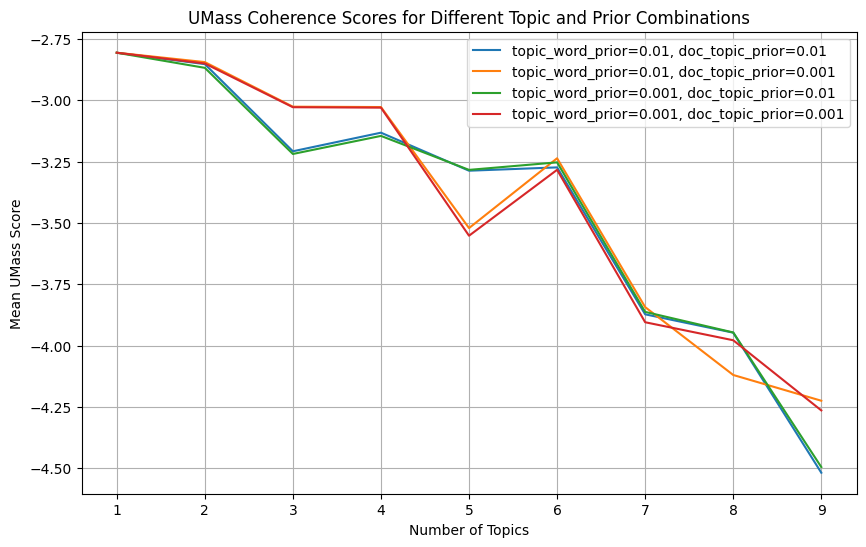

In [80]:
# Plot the mean UMass scores vs number of topics
plt.figure(figsize=(10, 6))
for twp in trump_records['topic_word_prior'].unique():
    for dtp in trump_records['doc_topic_prior'].unique():
        subset = trump_records[(trump_records['topic_word_prior'] == twp) & (trump_records['doc_topic_prior'] == dtp)]
        plt.plot(subset['topics'], subset['mean_umass'], label=f"topic_word_prior={twp}, doc_topic_prior={dtp}")

# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Mean UMass Score')
plt.title('UMass Coherence Scores for Different Topic and Prior Combinations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [89]:
#Find the best parameters and topic. The one with the lowest score closest to 0.
#Closer to 0 means the most coherence
best_params_trump, best_score_trump = get_best_score(trump_records)
print("The best parameters are", best_params_trump)
print("The best score is", best_score_trump)

The best parameters are {'topics': 1.0, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
The best score is -2.806532451312824


In [92]:
#Get the best model and train on the rest of the data
#Ensure that topic is an integer
best_params_trump['topics'] = int(best_params_trump['topics'])
best_lda_component_trump, best_vocab_trump = lda_model(trump_dtm, trump_vectorizer,**best_params_trump)

In [96]:
topn = 10
# Top words for the topic
for top in range(best_params_trump['topics']):
    top_words = best_lda_component_trump[top,:].argsort()[-topn:][::-1].tolist()
    words = best_vocab_trump[top_words]
    print(f"Topic {top} words: {'|'.join(words)}")

Topic 0 words: vote|donaldtrump|people|like|election|president|maga|america|biden|know


#### Biden

In [97]:
#Repeat the same thing for biden
biden_dtm, biden_vectorizer = create_dtm(biden_tweets,'no_stopwords')
biden_dtm.head()

,abc,able,absolutely,accept,according,account,across,action,actual,actually,...,wtpblue,wtpsenate,yeah,year,yesterday,york,young,yourefired,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
np.random.seed(0)

# Sample 10000 rows directly from the sparse matrix without converting the entire matrix to dense format
sample_indices_biden = np.random.choice(biden_dtm.shape[0], 10000, replace=False)

# Convert only the sampled rows to a dense DataFrame
sample_biden = pd.DataFrame(biden_dtm.iloc[sample_indices_biden])

In [100]:
#Run with a small sample first
biden_records = train_and_evaluate(lda_model, lda_params, sample_biden, biden_vectorizer, top_words=10)

Running model with parameters: {'topics': 1, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 1, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 2, 'topic_word_prior': 0.001, 'doc_topic_prior': 0.001}
Running model with parameters: {'topics': 3, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
Running model with parameters: {'topics': 3, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.001}
Running model with parameters: 

In [101]:
biden_records

,topics,topic_word_prior,doc_topic_prior,mean_umass
0,1,0.010,0.010,-2.767509
1,1,0.010,0.001,-2.767509
2,1,0.001,0.010,-2.767509
3,1,0.001,0.001,-2.767509
4,2,0.010,0.010,-3.070364
5,2,0.010,0.001,-3.070364
6,2,0.001,0.010,-3.070468
7,2,0.001,0.001,-3.070364
8,3,0.010,0.010,-3.354046
9,3,0.010,0.001,-3.326980


In [102]:
#Save the results to csv
biden_records.to_csv('data/lda_biden.csv', index = False)

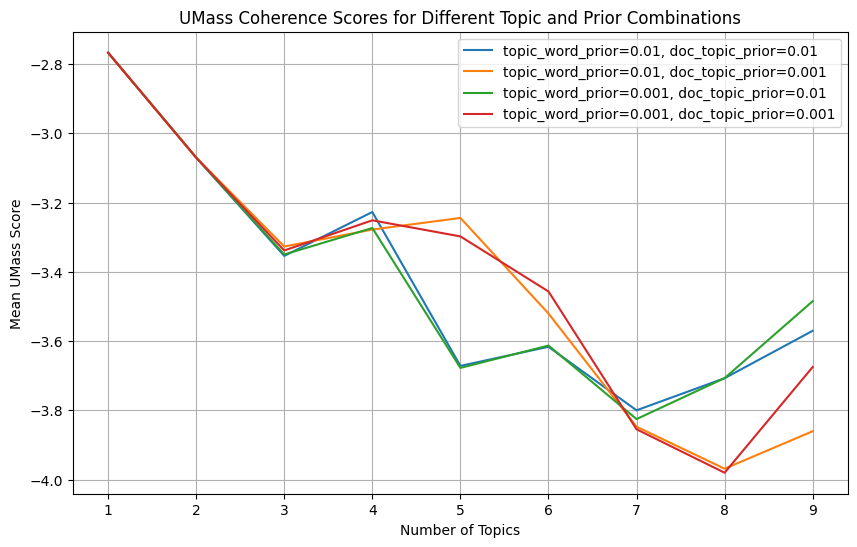

In [103]:
# Plot the mean UMass scores vs number of topics
plt.figure(figsize=(10, 6))
for twp in biden_records['topic_word_prior'].unique():
    for dtp in biden_records['doc_topic_prior'].unique():
        subset = biden_records[(biden_records['topic_word_prior'] == twp) & (biden_records['doc_topic_prior'] == dtp)]
        plt.plot(subset['topics'], subset['mean_umass'], label=f"topic_word_prior={twp}, doc_topic_prior={dtp}")

# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Mean UMass Score')
plt.title('UMass Coherence Scores for Different Topic and Prior Combinations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [104]:
#Find the best parameters and topic. The one with the lowest score closest to 0.
#Closer to 0 means the most coherence
best_params_biden, best_score_biden = get_best_score(biden_records)
print("The best parameters are", best_params_biden)
print("The best score is", best_score_biden)

The best parameters are {'topics': 1.0, 'topic_word_prior': 0.01, 'doc_topic_prior': 0.01}
The best score is -2.7675093018839596


In [105]:
#Get the best model and train on the rest of the data
#Ensure that topic is an integer
best_params_biden['topics'] = int(best_params_biden['topics'])
best_lda_component_biden, best_vocab_biden = lda_model(biden_dtm, biden_vectorizer,**best_params_biden)

In [106]:
topn = 10

# Top words for the topic
for top in range(best_params_biden['topics']):
    top_words = best_lda_component_biden[top,:].argsort()[-topn:][::-1].tolist()
    words = best_vocab_biden[top_words]
    print(f"Topic {top} words: {'|'.join(words)}")

Topic 0 words: joebiden|trump|vote|president|election|like|people|america|kamalaharris|know


### BERTopic

## Engagement Metrics

## Visualization

### Word Cloud

### US Sentiment Visualization

### Sentiment Visualization Tool